# This file is used to visualize/explore wrestler push-score.

In [4]:
import matplotlib as mpltlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests, re, json
from bs4 import BeautifulSoup
import math
import kimarite_helper

In [3]:
plt.style.use('ggplot')

In [4]:

def kimarite_list_by_name(rikishi_list):
    #f = open("kimarite.txt", "w")
    base_URL = "http://sumodb.sumogames.de/"
    shikona_search_URL = "http://sumodb.sumogames.de/Rikishi.aspx?shikona="


    # for id in range(xxxx, xxxx): # will need this for everybody else 

    # this will look like  [ ("Takakeisho", [url_to_kimarite]),  ... ]
    kimarite_URL_collection = []

    for rikishi in rikishi_list:

        # get the wrestler's page by searching their name
        basepage = requests.get(shikona_search_URL + rikishi)
        soup = BeautifulSoup(basepage.content, 'html.parser')
        
        # if shikona is unique, there will by a 'bouts by kimarite' link
        kimarite_page = soup.find('a', href = re.compile(r'Rikishi_kim*'))

        # if it's not unique, you will come to a page with a table of wrestlers
        # with this shikona by date. get the last one
        # example: http://sumodb.sumogames.de/Rikishi.aspx?shikona=Terao
        if not kimarite_page:
            print(f"non-unique shikona found ({rikishi})...")
            kimarite_page = soup.find('tbody').findAll('a', href = re.compile(r'Rikishi.aspx'))
            basepage = requests.get("http://sumodb.sumogames.de/" + kimarite_page[-1]['href'])
            soup = BeautifulSoup(basepage.content, 'html.parser')
            kimarite_page = soup.find('a', href = re.compile(r'Rikishi_kim*'))
        
        print(kimarite_page['href'])
        kimarite_URL_collection.append( (rikishi, base_URL + kimarite_page['href']) )



    # pie chart requires size and label lists. so, we will make a list like [ ( "Name", [kimarite_name, ...], [kimarite_amt, ...] ),   ... ] 
    kimarite = []

    for (shikona, kimarite_URL) in kimarite_URL_collection:
        print(f"processing {shikona}...")
        basepage = requests.get(kimarite_URL)
        soup = BeautifulSoup(basepage.content, 'html.parser')
    
        # get winning data table 
        kimarite_wins = soup.find('table', class_="ro_left")
            
        # this gets all winning moves in like [<tr><td class="rb_kim">oshidashi</td><td class="right"><a href="#0oshidashi">143</a></td></tr>, ...]
        cells = kimarite_wins.find_all('tr')

        kimarite_labels, kimarite_amts = [], []

        for cell in cells:
            win_name_tag, win_amt_tag = cell.find_all('td')
            kimarite_labels.append(win_name_tag.text.strip())
            kimarite_amts.append(int(win_amt_tag.text.strip()))
        

        # at this point we have all kimarite. reduce it so that only moves with >= 10% significance are displayed
        up_to_index = 0
        total_wins = sum(kimarite_amts)
        for i in range(0, len(kimarite_amts)):
            amt = kimarite_amts[i]
            # we find the most significant kimarite under 10%
            if amt / total_wins < 0.05:
                up_to_index = i
                break

        # we now slice off everything up to and past this point, label it as 'other'
        kimarite_labels = kimarite_labels[:up_to_index] + ["other"]
        kimarite_amts = kimarite_amts[:up_to_index] + [sum(kimarite_amts[up_to_index:])]
        
        print(kimarite_labels)
        print(kimarite_amts)
        
        #print((shikona, kimarite_amts, kimarite_labels))
        kimarite.append((shikona, kimarite_labels, kimarite_amts))

    print("done extracting kimarite!")
    return kimarite
    
    

In [9]:
def make_graphs(fighters):

    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.rcParams["figure.figsize"] = (20, math.ceil(len(fighters)/4)*5)



    fig, axs = plt.subplots(math.ceil(len(fighters)/4), 4)
    axs = axs.flatten()
    ai = 0
    color_group_general = {
                'Kihonwaza: Basic technique': 'red',
                'Nagete: Throwing technique': 'blue',
                'Kakete: Leg tripping technique': 'green',
                'Hinerite: Twist down technique': 'black',
                'Sorite: Backwards body drop': 'brown',
                'Tokushuwaza: Special technique': 'yellow',
                'Higi: Non-technique': 'gray',
                'Others': 'gray',
                None: 'gray'
    } 


    for (rikishi, kimarite_labels, kimarite_amts) in kimarite_list_by_name(fighters):

        ax1 = axs[ai]

        n = sum(kimarite_amts)
        w = 0 
        for i in range(0, len(kimarite_amts)):
            w += kimarite_amts[i] if kimarite_helper.is_oshi(kimarite_labels[i]) else 0
        p = w / n

        # explode top three kimarite
        explode = tuple( [0.05]*3 + ([0] * (len(kimarite_labels)-3)) )
        
        #colors = [color_group_general[kimarite_helper.classify(x)] for x in kimarite_labels]
        # highlighting oshi sumo
        colors = ['red' if kimarite_helper.is_oshi(x) else 'blue' for x in kimarite_labels]

        ax1.pie(kimarite_amts, explode=explode, labels=kimarite_labels, autopct='%1.1f%%',
                shadow=True, startangle=90, #textprops={'color':"b"}, 
                #colors=map(lambda x: color_d[kimarite_helper.classify(x)], kimarite_labels)
                colors=colors
                )
        # "{:.2f}".format(a)
        ax1.title.set_color('black')
        ax1.axis('equal')  
        ax1.set_title( rikishi + " (n=%s, p=%s, m=%s" % (n, "{:.2f}".format(p), "{:.2f}".format((0.5 - p)  * math.log10(n))) + ")")
        
        ai += 1
    
    while ai < 4 * math.ceil(len(fighters)/4):
        axs[ai].axis('off')
        ai += 1
    
    plt.show()

Rikishi_kim.aspx?r=12191
Rikishi_kim.aspx?r=8
Rikishi_kim.aspx?r=12094
Rikishi_kim.aspx?r=12043
Rikishi_kim.aspx?r=11985
non-unique shikona found (Terao)...
Rikishi_kim.aspx?r=6472
non-unique shikona found (Takanosho)...
Rikishi_kim.aspx?r=11855
processing Takakeisho...
['oshidashi', 'tsukiotoshi', 'hatakikomi', 'tsukidashi', 'hikiotoshi', 'oshitaoshi', 'other']
[143, 37, 33, 30, 18, 17, 25]
processing Chiyotaikai...
['oshidashi', 'hatakikomi', 'tsukidashi', 'hikiotoshi', 'tsukiotoshi', 'yorikiri', 'other']
[265, 136, 128, 50, 48, 42, 104]
processing Abi...
['oshidashi', 'hatakikomi', 'hikiotoshi', 'tsukidashi', 'uwatenage', 'other']
[75, 48, 36, 31, 19, 64]
processing Onosho...
['oshidashi', 'yorikiri', 'hatakikomi', 'oshitaoshi', 'hikiotoshi', 'other']
[145, 42, 30, 19, 18, 82]
processing Daieisho...
['oshidashi', 'tsukidashi', 'hatakikomi', 'tsukiotoshi', 'hikiotoshi', 'yorikiri', 'other']
[150, 52, 40, 32, 24, 22, 61]
processing Terao...
['yorikiri', 'oshidashi', 'uwatenage', 'kote

<Figure size 1440x1080 with 0 Axes>

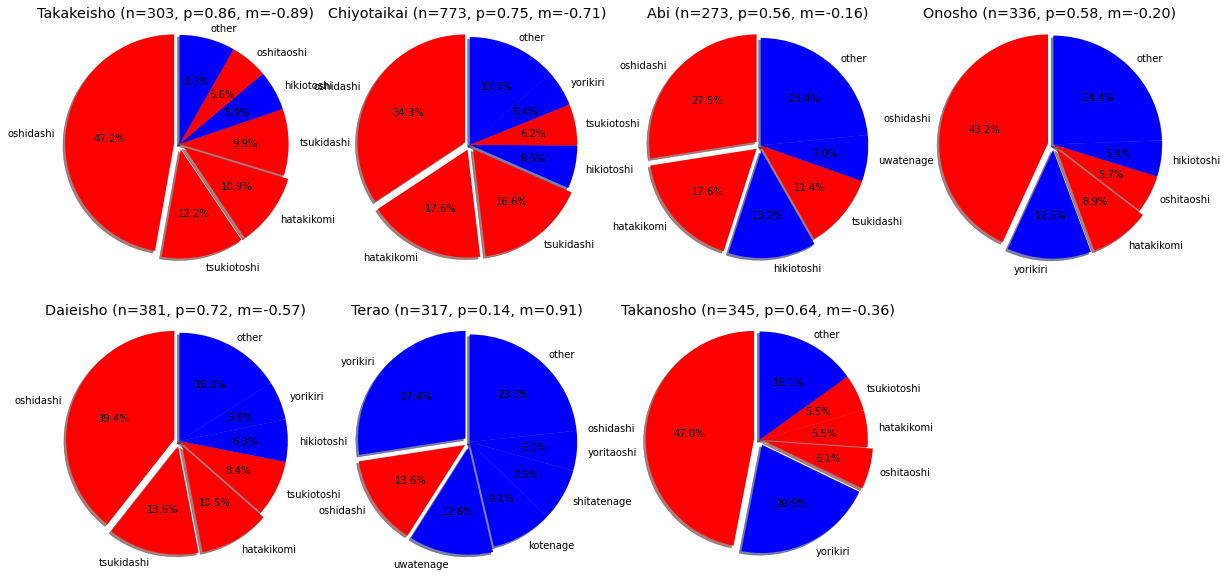

Rikishi_kim.aspx?r=12451
Rikishi_kim.aspx?r=11868
Rikishi_kim.aspx?r=1111
Rikishi_kim.aspx?r=12107
Rikishi_kim.aspx?r=12412
Rikishi_kim.aspx?r=6599
non-unique shikona found (Terunofuji)...
Rikishi_kim.aspx?r=11927
non-unique shikona found (Takarafuji)...
Rikishi_kim.aspx?r=11728
non-unique shikona found (Hakuho)...
Rikishi_kim.aspx?r=1123
Rikishi_kim.aspx?r=878
Rikishi_kim.aspx?r=4
Rikishi_kim.aspx?r=1
processing Hoshoryu...
['yorikiri', 'shitatenage', 'oshidashi', 'uwatenage', 'sotogake', 'hatakikomi', 'kotenage', 'uchigake', 'other']
[20, 14, 12, 12, 7, 6, 6, 6, 32]
processing Terutsuyoshi...
['oshidashi', 'yorikiri', 'shitatenage', 'other']
[94, 61, 29, 164]
processing Harumafuji...
['yorikiri', 'oshidashi', 'uwatenage', 'shitatenage', 'uwatedashinage', 'other']
[254, 126, 87, 51, 49, 264]
processing Ichinojo...
['yorikiri', 'oshidashi', 'hatakikomi', 'uwatenage', 'other']
[137, 43, 36, 30, 79]
processing Enho...
['shitatenage', 'yorikiri', 'oshidashi', 'ashitori', 'hikiotoshi', 'sh

<Figure size 1440x720 with 0 Axes>

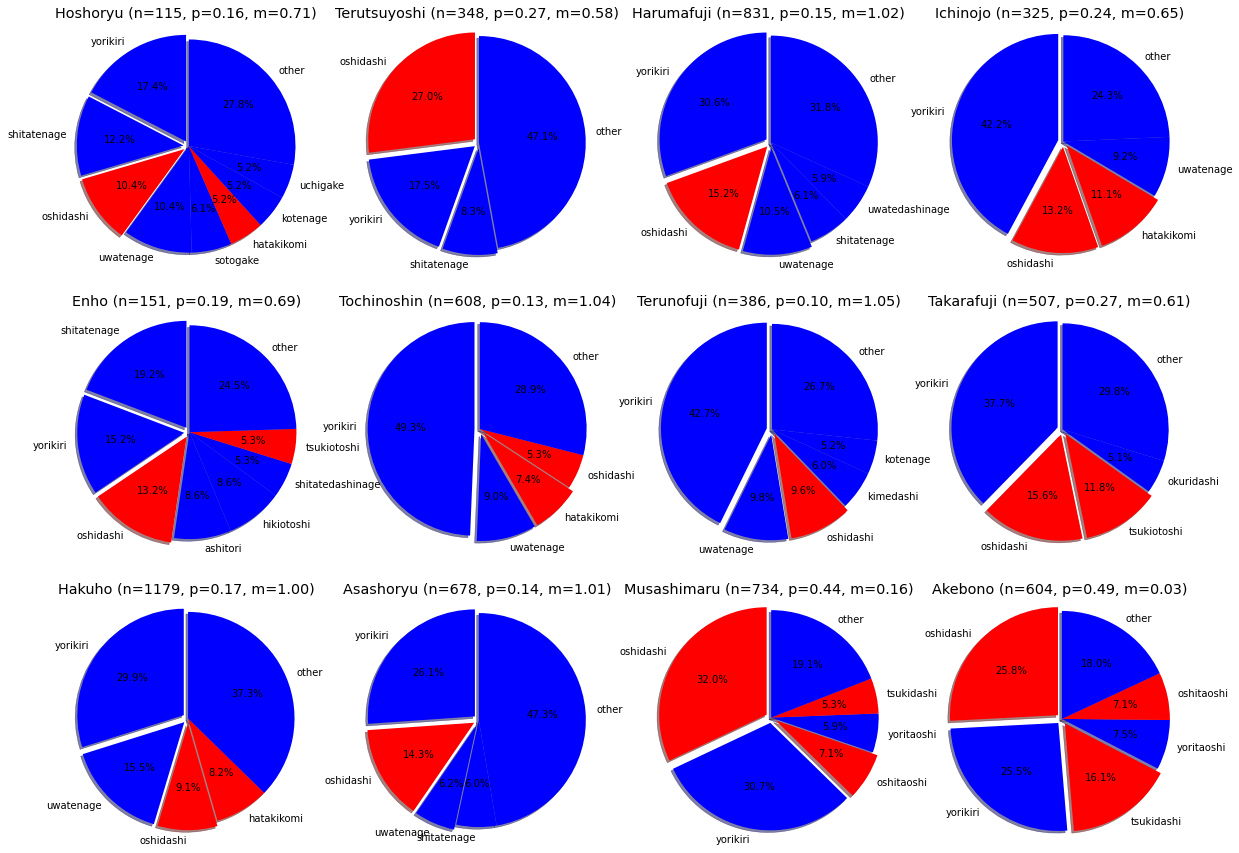

In [10]:

"""
considerations
    - oshi vs "all others" -- does this only encompass yotsu? (enho, terustuyoshi)
    - rank difference? <- this is kind of a big undertaking for analysis
    - expected wins for rank + # of recent wins/winning tournaments
    - cont. pusher metric

inputs
    - current rank
    - recent streak/performances
    - push sumo y/n
    - local order matters, input date as var

outputs
    - some difference metric
        - #w - E(w)

logistic/SVM
sklearn lib
"""


thrusters = [
	"Takakeisho", 
	"Chiyotaikai", 
    "Abi",
    "Onosho",
    "Daieisho",
    "Terao", # this gets the wrong terao
    "Takanosho",
]



not_thrusters = [
    "Hoshoryu",
    "Terutsuyoshi",
    "Harumafuji",
    "Ichinojo",
    "Enho",
    "Tochinoshin",
    "Terunofuji",
    "Takarafuji",
    "Hakuho",
    "Asashoryu",
    "Musashimaru", #these two transitioned to equal parts 
	"Akebono",
]


#make_graphs(["Enho", "Hoshoryu"])
#make_graphs(thrusters)
make_graphs(thrusters)
make_graphs(not_thrusters)
#make_graphs(["Daieisho", "Tochinoshin", "Terunofuji", "Enho"])


Glossary:



*   **Shikona** - wrestler's name
*   **Rikishi** - wrestler
*   **Basho** - the bimonthly tournament
*   **Mawashi** - the belt each rikishi wears
*   **Oshi sumo** - style of sumo which involves a lot of pushing techniques
*   **Yotsu sumo** -  style of sumo involving focusing on belt grips
*   **Kimarite** - the winning move of a bout
*   ****
